In [1]:
%matplotlib inline

import pandas as pd
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as py
from plotly.subplots import make_subplots
import numpy as np

py.init_notebook_mode()

In [2]:
platforms = ["Pitchfork", "Guardian", "NME", "Spectrum"]
dfs = {platform: 
       pd.read_hdf("C:\\Users\\tommy\\OneDrive\\University\\Year 3\\Third Year Project\\Platform Album Data\\review_data_final.h5", key=platform) for platform in platforms}

In [3]:
# Exploring score missing data

for platform, df in dfs.items():
    
    df.loc[:, "Scores"] = pd.to_numeric(df.loc[:, "Scores"])

for platform in platforms:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Scores"] == -1].shape[0])

Pitchfork:  0
Guardian:  0
NME:  0
Spectrum:  810


All fine except spectrum which seems to be missing a lot of scores. I have cross validated this with the urls and the reviews do not have a listed score on the website so this is no error. We therefore have much less data to work with with regard to spectrum.

In [4]:
# Exploring genre missing data

for platform in ["Guardian", "Pitchfork"]:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Genres"] == "NA"])

Guardian:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []
Pitchfork:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []


In [5]:
g_df = dfs["Guardian"]

len(g_df["Genres"].iloc[4])

1

In [6]:
def count_missing(x):
    
    if len(x) == 1:
        return 1
    
    else:
        return 0
    
g_df["Genres"].apply(count_missing).sum()

940

Since all lists are of length 1, we get the first element then repeat

In [7]:
g_df["Genres"] = g_df["Genres"].apply(lambda x: x[0])

g_df["Genres"]

0           electronicmusic, popandrock
1                            popandrock
2           popandrock, electronicmusic
3             popandrock, yeahyeahyeahs
4                                      
                     ...               
935                            pjharvey
936    hip-hop, popandrock, nicki-minaj
937                          popandrock
938                          popandrock
939                             hip-hop
Name: Genres, Length: 940, dtype: object

In [8]:
len(g_df["Genres"].iloc[4])

0

Now we can count missing

In [9]:
g_df["Genres"].apply(lambda x: len(x) == 0).sum()

77

There are 77 missing genres. This is only just less than 10% of the data so we will just remove these when analysing differences in genre classification.

In [10]:
# Let's take a look at what genres we have

g_df["Genres"].unique()

array(['electronicmusic, popandrock', 'popandrock',
       'popandrock, electronicmusic', 'popandrock, yeahyeahyeahs', '',
       'australian-music, rap', 'popandrock, r-and-b, dance-music',
       'popandrock, r-and-b, rap',
       'popandrock, dance-music, electronicmusic, dua-lipa, pharrellwilliams, ure/justin-timberlake',
       'popandrock, indie, experimental-music',
       'experimental-music, popandrock, indie',
       'popandrock, rap, dance-music, electronicmusic',
       'popandrock, anohni, sia-furler', 'americana, country',
       'arcadefire, popandrock, indie',
       'let-s-eat-grandma, electronicmusic, popandrock, indie',
       'popandrock, jazz', 'indie, punk', 'dance-music',
       'popandrock, indie', 'rosalia, the-weeknd, mia, hip-hop',
       'popandrock, christine-and-the-queens, caroline-polachek',
       'psychedelia, popandrock', 'hip-hop',
       'rap, odd-future-wolf-gang-kill-them-all', 'punk',
       'popandrock, phoebe-bridgers, ed-sheeran, snow-patrol',

Unfortunately this looks like time for a manual list of relevant genres. Oh dear.

We can at least make life a bit easier by splitting each into a list of genres rather than treating combinations as unique

In [11]:
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(", "))

g_df.loc[:, "Genres"]

0           [electronicmusic, popandrock]
1                            [popandrock]
2           [popandrock, electronicmusic]
3             [popandrock, yeahyeahyeahs]
4                                      []
                      ...                
935                            [pjharvey]
936    [hip-hop, popandrock, nicki-minaj]
937                          [popandrock]
938                          [popandrock]
939                             [hip-hop]
Name: Genres, Length: 940, dtype: object

In [12]:
genres_list = []

for genres in g_df["Genres"]:
    
    for genre in genres:
        
        if genre not in genres_list:
            genres_list.append(genre)
            
genres_list

['electronicmusic',
 'popandrock',
 'yeahyeahyeahs',
 '',
 'australian-music',
 'rap',
 'r-and-b',
 'dance-music',
 'dua-lipa',
 'pharrellwilliams',
 'ure/justin-timberlake',
 'indie',
 'experimental-music',
 'anohni',
 'sia-furler',
 'americana',
 'country',
 'arcadefire',
 'let-s-eat-grandma',
 'jazz',
 'punk',
 'rosalia',
 'the-weeknd',
 'mia',
 'hip-hop',
 'christine-and-the-queens',
 'caroline-polachek',
 'psychedelia',
 'odd-future-wolf-gang-kill-them-all',
 'phoebe-bridgers',
 'ed-sheeran',
 'snow-patrol',
 'gorillaz',
 'blur',
 'disco',
 'bts',
 '/selena-gomez',
 'metal',
 'andstyle/celebrity',
 'soul',
 'bruno-mars',
 'leon-bridges',
 'lil-wayne',
 'megan-thee-stallion',
 'stevie-nicks',
 'black-midi',
 'taylor-swift',
 'ety/youngpeople',
 'andstyle/relationships',
 'andstyle/women',
 'london-grammar',
 'dry-cleaning',
 'loretta-lynn',
 'ety/older-people',
 'd/feminism',
 'black-country-new-road',
 'folk',
 'dave-grohl',
 's/poetry',
 'arlo-parks',
 'thebeatles',
 'mark-ronson

In [13]:
# Manually reviewed

guardian_genres = ['electronicmusic',
 'popandrock',
 'australian-music',
 'rap',
 'r-and-b',
 'dance-music',
 'indie',
 'experimental-music',
 'americana',
 'country',
 'jazz',
 'punk',
 'hip-hop',
 'psychedelia',
 'disco',
 'metal',
 'soul',
 'folk',
 'clubs',
 'k-pop',
 'grime',
 'motown',
 'dubstep',
 'blues',
 'reggae',
 'classical-music-and-opera',
 'opera',
]

In [14]:
def filter_guardian(x):
    
    remove = []
    
    for genre in x:
        
        if genre not in guardian_genres:
            remove.append(genre)
            
    for genre in remove:
        x.remove(genre)
        
    if not x:
        x = ["NA"]
            
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(filter_guardian)
g_df = g_df.explode("Genres")

g_df.loc[:, "Genres"].unique()

array(['electronicmusic', 'popandrock', 'NA', 'australian-music', 'rap',
       'r-and-b', 'dance-music', 'indie', 'experimental-music',
       'americana', 'country', 'jazz', 'punk', 'hip-hop', 'psychedelia',
       'disco', 'metal', 'soul', 'folk', 'clubs', 'k-pop', 'grime',
       'motown', 'dubstep', 'blues', 'reggae',
       'classical-music-and-opera', 'opera'], dtype=object)

In [15]:
g_df.loc[g_df["Genres"] == "NA"].shape[0]

126

In [16]:
g_df.loc[:, "Genres"].value_counts()

popandrock                   609
indie                        209
NA                           126
electronicmusic               99
dance-music                   51
hip-hop                       51
r-and-b                       40
rap                           39
punk                          38
soul                          27
folk                          24
experimental-music            23
psychedelia                   19
americana                     13
country                       11
metal                         11
jazz                           9
clubs                          6
dubstep                        4
blues                          4
disco                          3
k-pop                          2
reggae                         2
australian-music               1
grime                          1
motown                         1
classical-music-and-opera      1
opera                          1
Name: Genres, dtype: int64

In [17]:
def group_small(x):
    
    if x in ["clubs", "dubstep", "blues", "disco", "k-pop", "reggae", "australian-music", "grime", "motown", "classical-music-and-opera"]:
        
        x = "Other"
        
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(group_small)

In [18]:
g_genres = g_df.loc[:, "Genres"].unique()

g_genres

array(['electronicmusic', 'popandrock', 'NA', 'Other', 'rap', 'r-and-b',
       'dance-music', 'indie', 'experimental-music', 'americana',
       'country', 'jazz', 'punk', 'hip-hop', 'psychedelia', 'metal',
       'soul', 'folk', 'opera'], dtype=object)

In [19]:
g_df.loc[g_df["Genres"] == "Other"]

Platform               Artist                        Album  \
6    Guardian      sampa the great            as above so below   
56   Guardian                 abba                       voyage   
117  Guardian        roisin murphy               roisin machine   
132  Guardian          jessie ware        what's your pleasure?   
142  Guardian            lady gaga                   chromatica   
169  Guardian          tame impala                the slow rush   
243  Guardian             slowthai  nothing great about britain   
264  Guardian          marvin gaye               you're the man   
283  Guardian          james blake                  assume form   
284  Guardian          james blake                  assume form   
360  Guardian               grimes                   art angels   
374  Guardian           disclosure                      caracal   
437  Guardian       alabama shakes              sound and color   
633  Guardian             cut copy               free your mind   
695  Guardian               austra                      olympia   
721  Guardian           snoop lion                 reincarnated   
722  Guardian           snoop lion                 reincarnated   
730  Guardian          james blake                    overgrown   
756  Guardian             darkstar            news from nowhere   
827  Guardian          jessie ware                     devotion   
863  Guardian  simian mobile disco                   unpatterns   
864  Guardian         damon albarn                       dr dee   
879  Guardian       alabama shakes               boys and girls   
880  Guardian       alabama shakes               boys and girls   
909  Guardian             lambchop                         mr m   

                                                  Text  Scores Genres  \
6    Sampa Tembo is no longer answering to Australi...       4  Other   
56   After 40 years, the makers of once-sparkling p...       2  Other   
117  Pop outsider and lockdown living-room star Mur...       4  Other   
132  Without the burden of reinvention, Ware’s four...       4  Other   
142  Returning to the sound of her maximalist elect...       4  Other   
169  Kevin Parker shifts further away from his psyc...       4  Other   
243  On his debut album, the Northampton rapper swe...       5  Other   
264  Remixed and repackaged collection finds a trou...       3  Other   
283  A love letter to his partner brimming with gue...       3  Other   
284  Blake is clearly in a good place, unexpectedly...       4  Other   
360   nless you explicitly set out to play authenti...       3  Other   
374   t begins not with a banger, but with a sultry...       3  Other   
437   owerhouses don’t come much more energised tha...       4  Other   
633   his is an homage to the music of the second s...       2  Other   
695   ad dance music is an art, and few do it well,...       4  Other   
721   or all his erstwhile gin, juice and pimpin', ...       2  Other   
722  Despite featuring Miley Cyrus, the drummer fro...       2  Other   
730   s album number two begins to trickles in, it ...       3  Other   
756   hose familiar with Darkstar's signature singl...       4  Other   
827  Jessie Ware doesn't seem to be gunning for pop...       4  Other   
863   as Shaw and James Ford have what might be cal...       4  Other   
864   ny casual fans wondering what that Gorillaz s...       3  Other   
879   labama Shakes are a double rarity in being bo...       4  Other   
880   t's not difficult to see why the Alabama Shak...       3  Other   
909   Kurt Wagner has addressed loss, death and the...       4  Other   

                                                   Url  
6    https://www.theguardian.com/music/2022/sep/09/...  
56   https://www.theguardian.com/music/2021/nov/05/...  
117  https://www.theguardian.com/music/2020/sep/24/...  
132  https://www.theguardian.com/music/2020/jun/04/...  
142  https://www.theguardian.com/music/2020/may/29/...  
169  https://www.theg

In [20]:
def remove_na(x):
    
    if len(x) > 1 and "NA" in x:
        x.remove("NA")
        
    return x

g_df_genre = g_df.loc[:, ["Artist", "Album", "Scores", "Genres"]]

g_df_genre = g_df_genre.groupby(by=["Artist", "Album"])["Genres"].aggregate(lambda x: ", ".join(tuple(x)))
g_df_genre = g_df_genre.reset_index()

g_df_genre.loc[:, "Genres"] = g_df_genre.loc[:, "Genres"].apply(lambda x: pd.Series(x.split(", ")).unique())
g_df = pd.merge(g_df.loc[:, g_df.columns != "Genres"], g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                how="left", on=["Artist", "Album"])

g_df["Genres"] = g_df["Genres"].apply(lambda x: " ".join(x))
g_df = g_df.drop_duplicates()

g_df = g_df.reset_index(drop=True)
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(" "))
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(remove_na)

g_df = g_df.explode("Genres").reset_index(drop=True)
g_df.head(5)

Platform     Artist                 Album  \
0  Guardian  brian eno  foreverandevernomore   
1  Guardian  brian eno  foreverandevernomore   
2  Guardian    shygirl                 nymph   
3  Guardian      bjork               fossora   
4  Guardian      bjork               fossora   

                                                Text  Scores  \
0  The producer contemplates the future of the pl...       4   
1  The producer contemplates the future of the pl...       4   
2  British rapper, DJ and singer-songwriter Blane...       4   
3  The pop auteur’s 10th album deals with the dea...       4   
4  The pop auteur’s 10th album deals with the dea...       4   

                                                 Url           Genres  
0  https://www.theguardian.com/music/2022/oct/16/...  electronicmusic  
1  https://www.theguardian.com/music/2022/oct/16/...       popandrock  
2  https://www.theguardian.com/music/2022/oct/02/...       popandrock  
3  https://www.theguardian.com/music/2022/oct/01/...       popandrock  
4  https://www.theguardian.com/music/2022/oct/01/...  electronicmusic

In [21]:
g_df.loc[g_df["Genres"] == "Other"].iloc[:5, :]

Platform           Artist                  Album  \
8    Guardian  sampa the great      as above so below   
90   Guardian             abba                 voyage   
92   Guardian             abba                 voyage   
185  Guardian    roisin murphy         roisin machine   
211  Guardian      jessie ware  what's your pleasure?   

                                                  Text  Scores  \
8    Sampa Tembo is no longer answering to Australi...       4   
90   The return of the Swedish super troupers has p...       3   
92   After 40 years, the makers of once-sparkling p...       2   
185  Pop outsider and lockdown living-room star Mur...       4   
211  The singer-songwriter swaps luxe pop for the e...       4   

                                                   Url Genres  
8    https://www.theguardian.com/music/2022/sep/09/...  Other  
90   https://www.theguardian.com/music/2021/nov/06/...  Other  
92   https://www.theguardian.com/music/2021/nov/05/...  Other  
185  https://www.theguardian.com/music/2020/sep/24/...  Other  
211  https://www.theguardian.com/music/2020/jun/28/...  Other

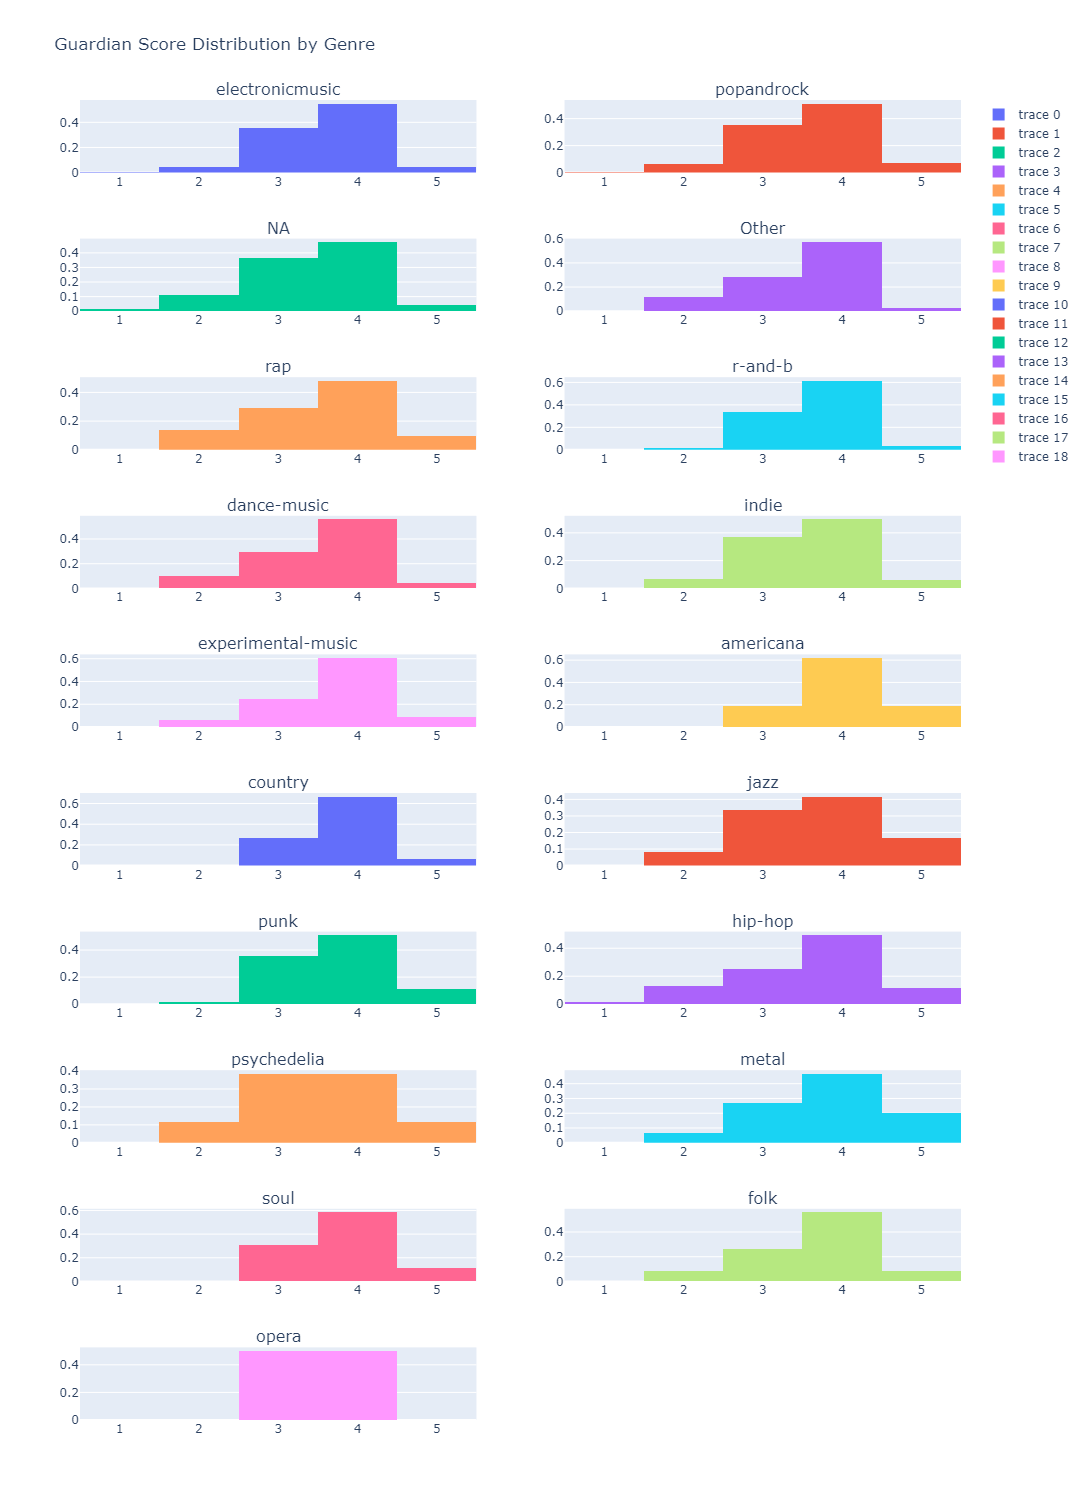

In [22]:
fig = make_subplots(rows=10, cols=2, subplot_titles=g_genres)

for i in range(1, 11):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
        
        if index >= len(g_genres):
            break
        
        genre = g_genres[2 * (i - 1) + j - 1]
        
        fig.add_trace(go.Histogram(x=g_df.loc[g_df["Genres"] == genre, "Scores"],
                                   xbins={"start": 0.5,
                                          "end": 5.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
                            
fig.update_layout(title_text="Guardian Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [23]:
# Pitchfork genre

pf_df = dfs["Pitchfork"]

def find_second_last(string, char):
    
    count = 0
    i = len(string)
    
    for c in string[::-1]:
        i -= 1
        
        if c == char:
            count += 1
            
            if count == 2:
                return i
            
    return -1

pf_df["Genres"].apply(lambda x: find_second_last(x, ",")).max()
                

64

All genres have had a date added so remove based on the second last comma

In [24]:
def remove_second_last(string, char):
    
    index = find_second_last(string, char)
    
    return string[:index]

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: remove_second_last(x, ","))
    
pf_df["Genres"]

0                           Electronic, Verve / UMC
1                         Electronic, Because Music
2      Electronic / Pop/R&B, One Little Independent
3                           Rock, Secretly Canadian
4                                      Rock, Domino
                           ...                     
935                  Rock, Vagrant / Island Def Jam
936                      Rap, Def Jam / Roc-A-Fella
937                                    Rock, Domino
938                                    Rock, Domino
939                                Rap, Roc-A-Fella
Name: Genres, Length: 940, dtype: object

In [25]:
pf_df["Genres"].unique()[:5]

array(['Electronic, Verve / UMC', 'Electronic, Because Music',
       'Electronic / Pop/R&B, One Little Independent',
       'Rock, Secretly Canadian', 'Rock, Domino'], dtype=object)

In [26]:
# Since pitchfork also collected label data we will remove that also

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: x[:x.find(",")])

In [27]:
pf_df["Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', '4A', 'Spinefar', 'Domin', 'Metal / Rock',
       'AT', 'Jazz / Pop/R&B',
       'RCA / Vice / Mad Decent / Berhane Sound Syste',
       'Electronic / Experimental', 'Captured Track', 'Fir',
       'Jazz / Rock', 'Experimental / Rap', "Honest Jon'"], dtype=object)

Doesn't that look lovely. Except it doesn't because there are still a fair few labels in there that have no genre.

In [28]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Global", "Spinefar", "Domin", "AT", "RCA / Vice / Mad Decent / Berhane Sound Syste", "Captured Track", "Fir",
                              "Honest Jon'"])]

Platform                     Artist                      Album  \
399  Pitchfork             omar souleyman               bahdeni nami   
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
634  Pitchfork             omar souleyman                  wenu wenu   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores  \
399  Syrian singer Omar Souleyman's first proper st...     6.2   
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
518  The latest effort from England’s reigning doom...     7.9   
576  Short bursts of anger snap into place in the d...     6.4   
634  Syrian singer Omar Souleyman’s Wenu Wenu is te...     7.2   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7   
721  Snoop Dogg's dalliance with reggae was documen...     5.0   
722  Snoop Dogg's dalliance with reggae was documen...     5.0   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0   
831  On their self-titled debut, the Stockholm band...     7.1   
845  A decade into their second career, Mission of ...     7.7   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   

                                            Genres  \
399                                         Global   
505                                             4A   
506                                             4A   
518                                       Spinefar   
576                                          Domin   
634                                         Global   
685                                             AT   
721  RCA / Vice / Mad Decent / Berhane Sound Syste   
722  RCA / Vice / Mad Decent / Berhane Sound Syste   
749                                             AT   
831                                 Captured Track   
845                                            Fir   
881                                    Honest Jon'   
882                                    Honest Jon'   

                                                   Url  
399  https://www.pitchfork.com/reviews/albums/20830...  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
634  https://www.pitchfork.com/reviews/albums/18665...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

Upon spot checking the only legitimate genre of the above list is global so we will set the rest to NA as they have no genre.

In [29]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Spinefar", "Domin", "AT", "Captured Track", "Fir",
                              "Honest Jon'", "RCA / Vice / Mad Decent / Berhane Sound Syste"]), "Genres"] = "NA"

pf_df.loc[pf_df["Genres"] == "NA"]

Platform                     Artist                      Album  \
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores Genres  \
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
518  The latest effort from England’s reigning doom...     7.9     NA   
576  Short bursts of anger snap into place in the d...     6.4     NA   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7     NA   
721  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
722  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0     NA   
831  On their self-titled debut, the Stockholm band...     7.1     NA   
845  A decade into their second career, Mission of ...     7.7     NA   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   

                                                   Url  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

In [30]:
pf_df.loc[:, "Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', 'NA', 'Metal / Rock', 'Jazz / Pop/R&B',
       'Electronic / Experimental', 'Jazz / Rock', 'Experimental / Rap'],
      dtype=object)

Much better.

In [31]:
def pitchfork_split(x):
    
    x = x.split(" / ")
    
    return [e.strip() for e in x]

pf_df.loc[:, "Genres"] = pf_df.loc[:, "Genres"].apply(pitchfork_split)

pf_df

Platform           Artist                              Album  \
0    Pitchfork        brian eno               foreverandevernomore   
1    Pitchfork          shygirl                              nymph   
2    Pitchfork            bjork                            fossora   
3    Pitchfork  yeah yeah yeahs                       cool it down   
4    Pitchfork           alex g               god save the animals   
..         ...              ...                                ...   
935  Pitchfork        pj harvey                  let england shake   
936  Pitchfork       kanye west  my beautiful dark twisted fantasy   
937  Pitchfork   arctic monkeys                             humbug   
938  Pitchfork   arctic monkeys                             humbug   
939  Pitchfork       kanye west                808s and heartbreak   

                                                  Text  Scores  \
0    Confronting the climate crisis and the prospec...     7.5   
1    Sensuous, funny, and smartly produced, the Lon...     8.0   
2    With her 10th album, Björk is grounded back on...     8.4   
3    The trio’s first album in nine years ushers in...     7.4   
4    Placing its faith in the healing power of anim...     8.4   
..                                                 ...     ...   
935  The always-unpredictable singer-songwriter ret...     8.8   
936  Kanye's big year culminates in an LP that feel...    10.0   
937  The Arctics expand their sound with the help o...     7.2   
938  The Arctics expand their sound with the help o...     7.2   
939   Poor Kanye West. The guy was already a ball o...     7.6   

                    Genres                                                Url  
0             [Electronic]  https://www.pitchfork.com/reviews/albums/brian...  
1             [Electronic]  https://www.pitchfork.com/reviews/albums/shygi...  
2    [Electronic, Pop/R&B]  https://www.pitchfork.com/reviews/albums/bjork...  
3                   [Rock]  https://www.pitchfork.com/reviews/albums/yeah-...  
4                   [Rock]  https://www.pitchfork.com/reviews/albums/alex-...  
..                     ...                                                ...  
935                 [Rock]  https://www.pitchfork.com/reviews/albums/15120...  
936                  [Rap]  https://www.pitchfork.com/reviews/albums/14880...  
937                 [Rock]  https://www.pitchfork.com/reviews/albums/13374...  
938                 [Rock]  https://www.pitchfork.com/reviews/albums/13374...  
939                  [Rap]  https://www.pitchfork.com/reviews/albums/12498...  

[940 rows x 7 columns]

In [32]:
pf_df = pf_df.explode("Genres")

In [33]:
pf_genres = pf_df.loc[:, "Genres"].unique()
len(pf_genres)

10

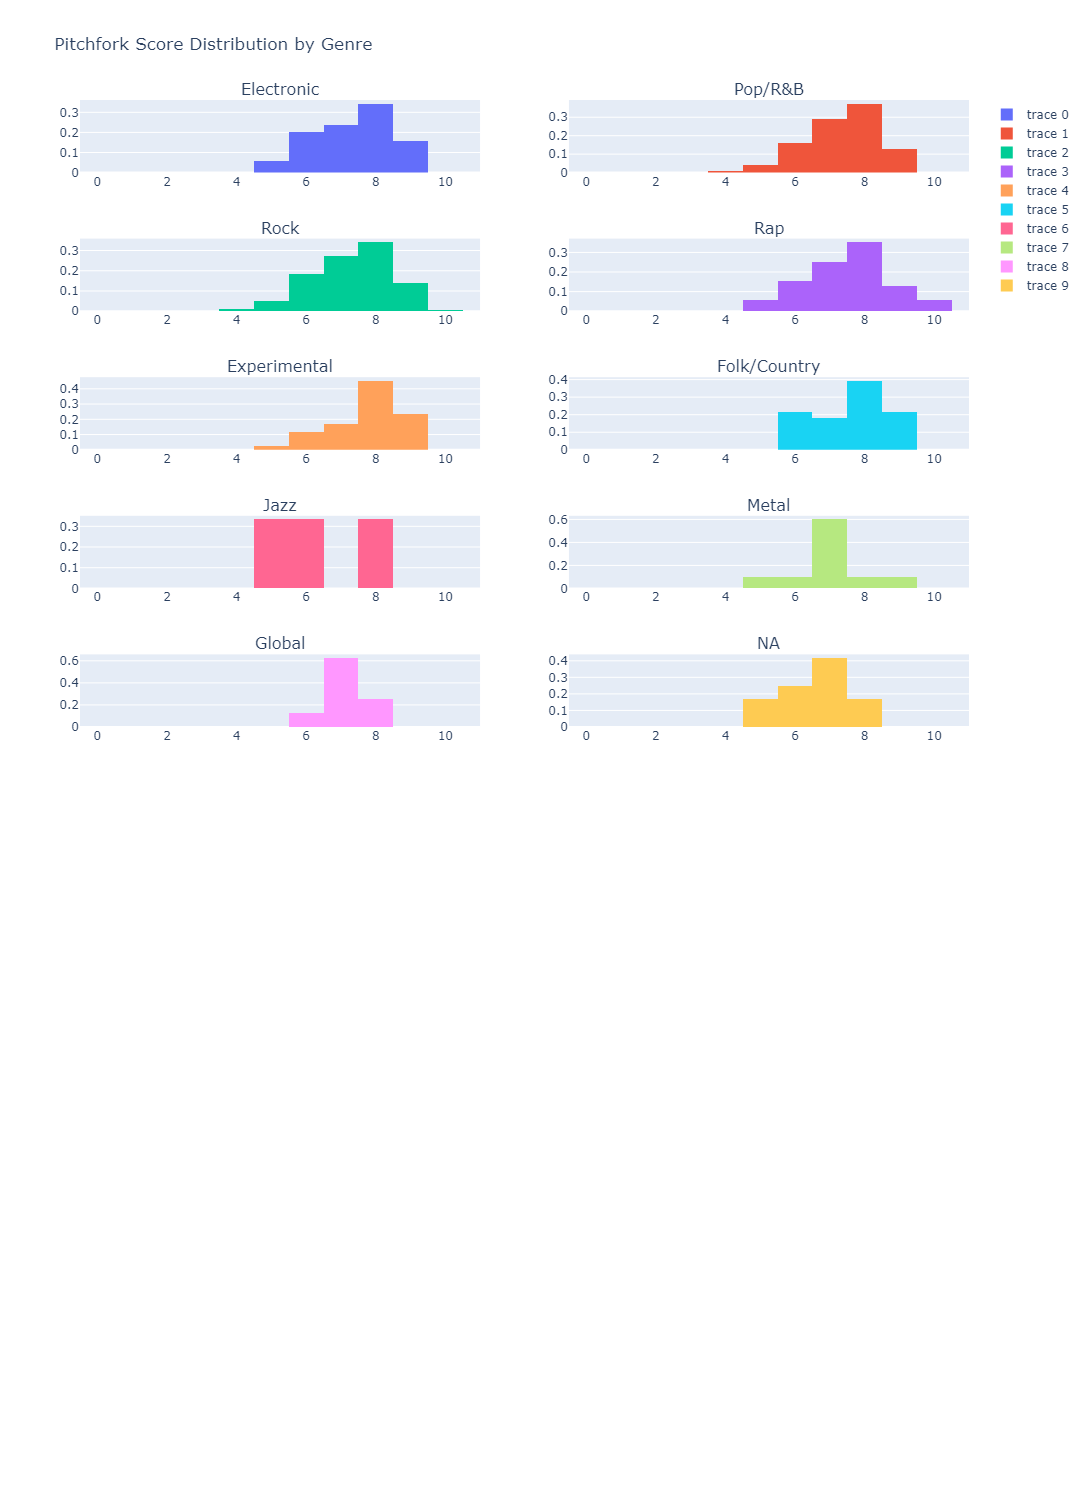

In [34]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1              
    
        if index >= len(pf_genres):
            break
    
        genre = pf_genres[index]
        
        fig.add_trace(go.Histogram(x=pf_df.loc[pf_df["Genres"] == genre, "Scores"],
                                   xbins={"start": -0.5,
                                          "end": 10.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[-0.5, 11])
        
fig

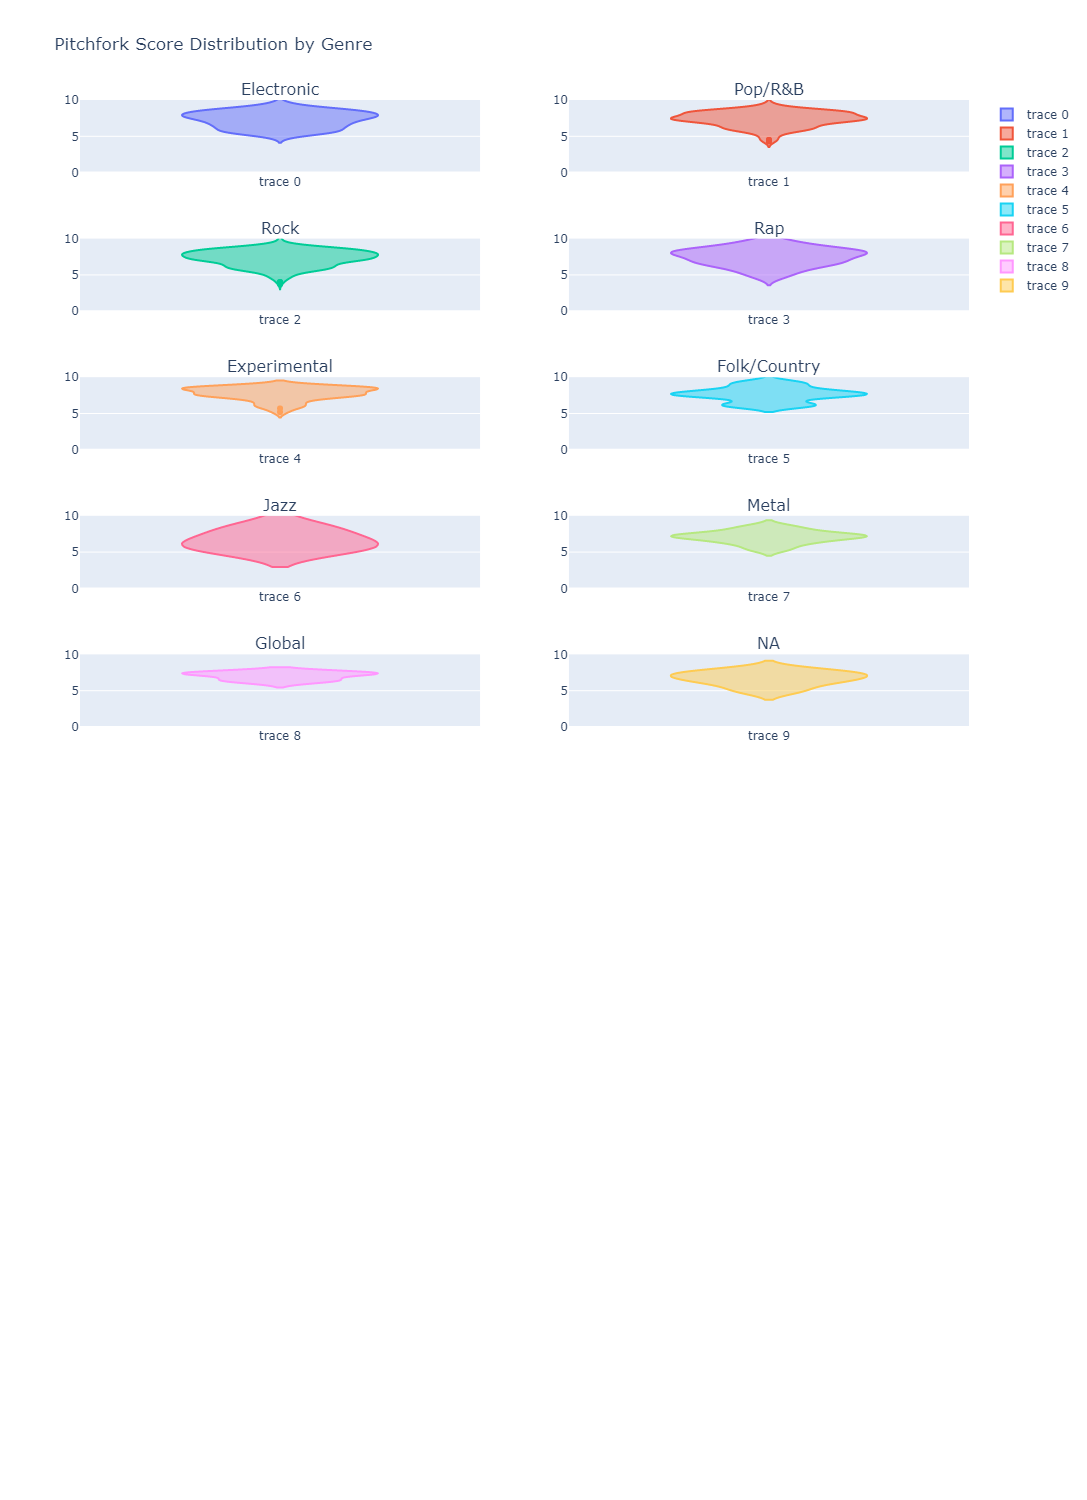

In [35]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
    
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]
        
        fig.add_trace(go.Violin(y=pf_df.loc[pf_df["Genres"] == genre, "Scores"]), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_yaxes(range=[0, 10])
        
fig

In [36]:
genre_df = pd.merge(g_df.loc[:, ["Artist", "Album", "Genres"]], pf_df.loc[:, ["Artist", "Album", "Genres"]],
                    how="inner", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Genres_x"], genre_df.loc[:, "Genres_y"])
genre_cross

Genres_y            Electronic  Experimental  Folk/Country  Global  Jazz  \
Genres_x                                                                   
NA                           4             9             5       1     0   
Other                        5             0             0       0     0   
americana                    0             0             2       0     0   
country                      0             0             3       0     0   
dance-music                 26             0             0       2     1   
electronicmusic             45             3             0       3     0   
experimental-music           6             2             1       1     0   
folk                         0             2             8       0     0   
hip-hop                      5             0             0       0     0   
indie                       13            10             4       0     0   
jazz                         2             2             0       0     0   
metal                        0             0             0       0     0   
opera                        0             0             0       0     0   
popandrock                  65            20            10       2     1   
psychedelia                  1             2             0       0     0   
punk                         1             0             0       0     0   
r-and-b                      4             0             0       0     0   
rap                          2             0             0       0     0   
soul                         2             0             0       0     2   

Genres_y            Metal  NA  Pop/R&B  Rap  Rock  
Genres_x                                           
NA                      1   0       11    6    34  
Other                   0   1        9    2     7  
americana               0   0        0    0    10  
country                 0   0        0    0     6  
dance-music             0   0       12    2    12  
electronicmusic         0   1       25    3    21  
experimental-music      0   1        2    2    10  
folk                    0   0        1    0    11  
hip-hop                 0   1        9   33     1  
indie                   1   4       14    0   151  
jazz                    0   0        2    0     3  
metal                   2   2        0    0     6  
opera                   0   0        0    0     1  
popandrock              7   6      101   29   261  
psychedelia             0   0        0    0    16  
punk                    1   1        0    2    32  
r-and-b                 0   0       29    0     3  
rap                     0   1        7   22     0  
soul                    0   0       12    3     8

Let's try grouping together intuitively

In [37]:
mappings = {"dance-music": "electronic",
            "electronicmusic": "electronic",
            "folk": "folk_country",
            "country": "folk_country",
            "americana": "folk_country",
            "hip-hop": "rap"}

def map_g_genre(x):
    
    if x in mappings.keys():
        x = mappings[x]
        
    return x

mapped_g_df = g_df.copy()
mapped_g_df.loc[:, "Genres"] = mapped_g_df.loc[:, "Genres"].apply(map_g_genre)

mapped_genre_df = pd.merge(mapped_g_df.loc[:, ["Artist", "Album", "Genres"]], pf_df.loc[:, ["Artist", "Album", "Genres"]],
                    how="outer", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

mapped_genre_cross = pd.crosstab(mapped_genre_df.loc[:, "Genres_x"], mapped_genre_df.loc[:, "Genres_y"])
mapped_genre_cross

Genres_y            Electronic  Experimental  Folk/Country  Global  Jazz  \
Genres_x                                                                   
NA                           4             9             5       1     0   
Other                        5             0             0       0     0   
electronic                  57             3             0       3     1   
experimental-music           6             2             1       1     0   
folk_country                 0             2            11       0     0   
indie                       13            10             4       0     0   
jazz                         2             2             0       0     0   
metal                        0             0             0       0     0   
opera                        0             0             0       0     0   
popandrock                  65            20            10       2     1   
psychedelia                  1             2             0       0     0   
punk                         1             0             0       0     0   
r-and-b                      4             0             0       0     0   
rap                          6             0             0       0     0   
soul                         2             0             0       0     2   

Genres_y            Metal  NA  Pop/R&B  Rap  Rock  
Genres_x                                           
NA                      1   0       11    6    34  
Other                   0   1        9    2     7  
electronic              0   1       29    3    29  
experimental-music      0   1        2    2    10  
folk_country            0   0        1    0    23  
indie                   1   4       14    0   151  
jazz                    0   0        2    0     3  
metal                   2   2        0    0     6  
opera                   0   0        0    0     1  
popandrock              7   6      101   29   261  
psychedelia             0   0        0    0    16  
punk                    1   1        0    2    32  
r-and-b                 0   0       29    0     3  
rap                     0   1       12   38     1  
soul                    0   0       12    3     8

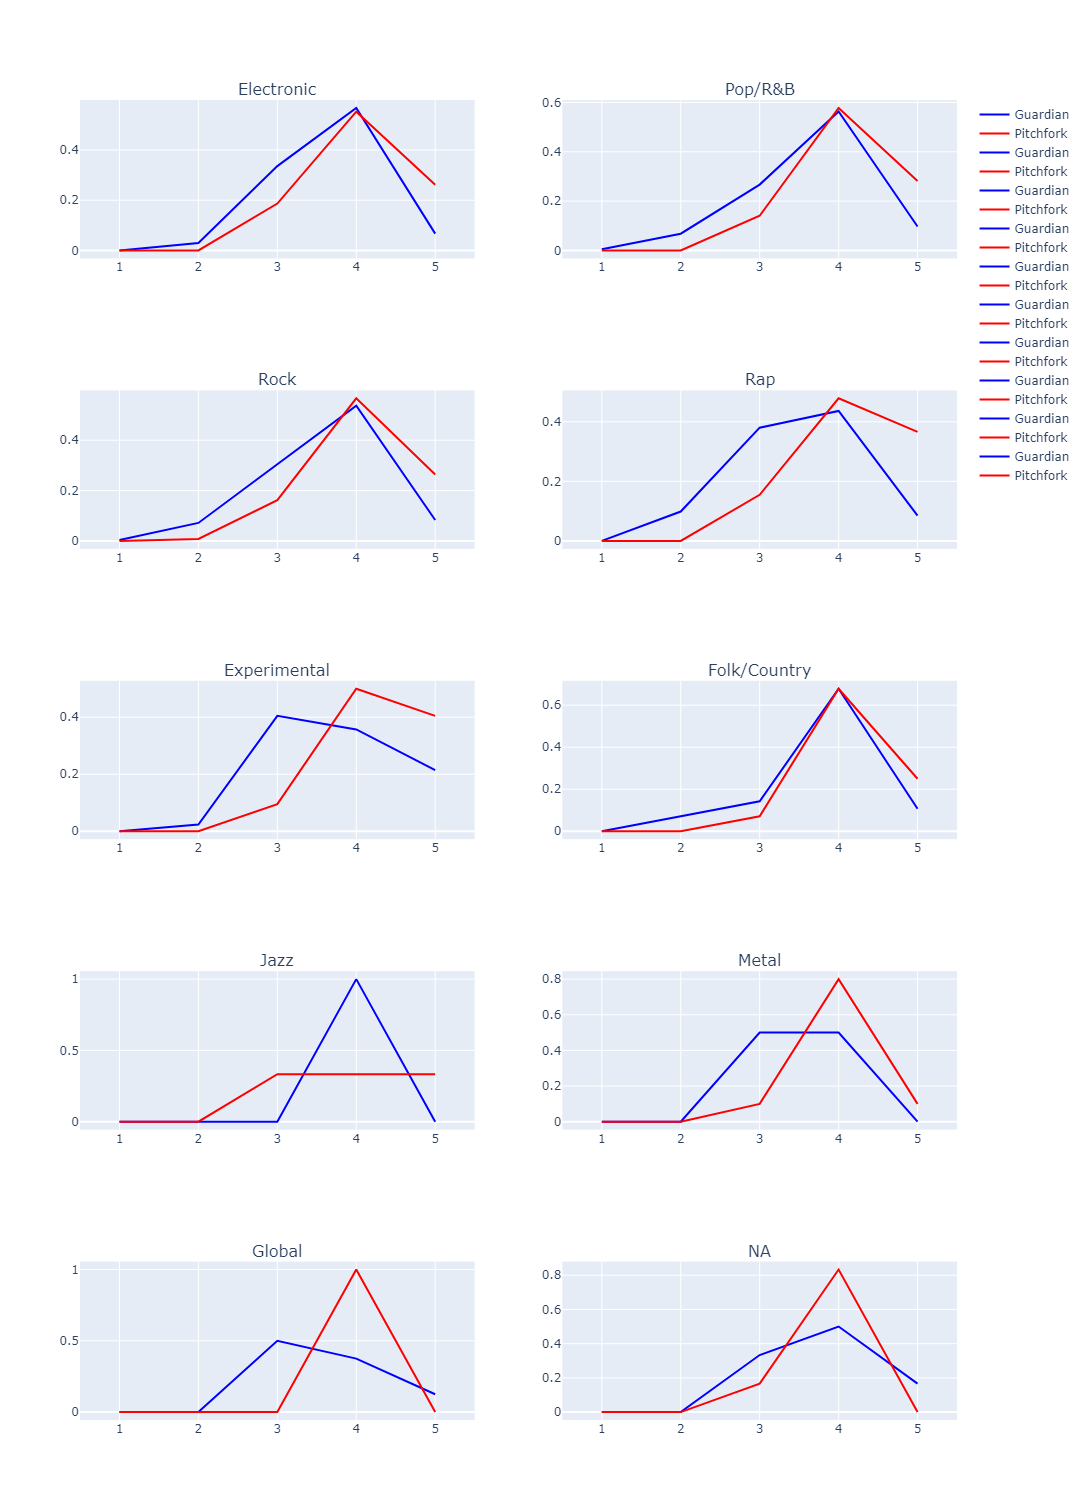

In [38]:
from math import ceil

fig = make_subplots(rows=5, cols=2, subplot_titles=pf_genres)
dist_g = g_df.copy()
dist_pf = pf_df.copy()

dist_g.loc[:, "Genres"] = dist_pf.loc[:, "Genres"].reset_index(drop=True)

dist_df = pd.concat([dist_g.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]], 
                   dist_pf.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]]]).reset_index(drop=True)

dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"] = dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"].apply(lambda x: ceil(x / 2))

dist_data = {}

for genre in pf_genres:
    
    g_genre_data = dist_df.loc[(dist_df["Platform"] == "Guardian") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    pf_genre_data = dist_df.loc[(dist_df["Platform"] == "Pitchfork") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    
    dist_data[genre] = [pd.DataFrame({"Platform": ["Guardian" for x in range(g_genre_data.shape[0])],
                                                "Scores": g_genre_data.index,
                                                "Proportion": g_genre_data.values}).sort_values("Scores"),
                                  pd.DataFrame({"Platform": ["Pitchfork" for x in range(pf_genre_data.shape[0])],
                                                "Scores": pf_genre_data.index,
                                                "Proportion": pf_genre_data.values}).sort_values("Scores")]

for i in range(1, 6):
    for j in range(1, 3):

        index = 2 * (i - 1) + j - 1
        
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]        
        fig.add_trace(go.Scatter(x=dist_data[genre][0].loc[:, "Scores"], y=dist_data[genre][0].loc[:, "Proportion"], mode="lines",
                                line=dict(color="blue"), name="Guardian"), row=i, col=j)
        fig.add_trace(go.Scatter(x=dist_data[genre][1].loc[:, "Scores"], y=dist_data[genre][1].loc[:, "Proportion"], mode="lines",
                                line=dict(color="red"), name="Pitchfork"), row=i, col=j)

fig.update_layout(height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [39]:
g_df_ave = g_df.groupby(by=["Album", "Artist"])["Scores"].mean().reset_index()
g_df_ave = pd.merge(g_df_ave, g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                    on=["Artist", "Album"], how="inner")

dfs_ave = {k: df.drop_duplicates(subset=["Artist", "Album"]) for k, df in dfs.items()}
dfs_ave["Guardian"] = g_df_ave

[df.shape[0] for df in dfs_ave.values()]

[641, 641, 641, 641]

In [40]:
g_df_ave

Album        Artist  Scores  \
0              1989  taylor swift     4.0   
1                 2   mac demarco     3.0   
2                25         adele     3.0   
3              2:54          2:54     2.0   
4                 4       beyonce     3.5   
..              ...           ...     ...   
636          yeezus    kanye west     4.0   
637    you're dead!  flying lotus     5.0   
638  you're nothing        iceage     3.0   
639  you're the man   marvin gaye     3.0   
640            yuck          yuck     4.0   

                                      Genres  
0                           [NA, popandrock]  
1                                    [indie]  
2                               [popandrock]  
3                                    [indie]  
4                      [r-and-b, popandrock]  
..                                       ...  
636  [hip-hop, electronicmusic, dance-music]  
637         [jazz, electronicmusic, hip-hop]  
638                        [NA, punk, metal]  
639                   [soul, r-and-b, Other]  
640                                  [indie]  

[641 rows x 4 columns]

In [41]:
pf_df_ave = dfs_ave["Pitchfork"]

genre_df_ave = pd.merge(g_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]], 
                        pf_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]],
                    how="inner", on=["Artist", "Album"]).reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Genres_x"], genre_df.loc[:, "Genres_y"])
genre_cross

Genres_y            Electronic  Experimental  Folk/Country  Global  Jazz  \
Genres_x                                                                   
NA                           4             9             5       1     0   
Other                        5             0             0       0     0   
americana                    0             0             2       0     0   
country                      0             0             3       0     0   
dance-music                 26             0             0       2     1   
electronicmusic             45             3             0       3     0   
experimental-music           6             2             1       1     0   
folk                         0             2             8       0     0   
hip-hop                      5             0             0       0     0   
indie                       13            10             4       0     0   
jazz                         2             2             0       0     0   
metal                        0             0             0       0     0   
opera                        0             0             0       0     0   
popandrock                  65            20            10       2     1   
psychedelia                  1             2             0       0     0   
punk                         1             0             0       0     0   
r-and-b                      4             0             0       0     0   
rap                          2             0             0       0     0   
soul                         2             0             0       0     2   

Genres_y            Metal  NA  Pop/R&B  Rap  Rock  
Genres_x                                           
NA                      1   0       11    6    34  
Other                   0   1        9    2     7  
americana               0   0        0    0    10  
country                 0   0        0    0     6  
dance-music             0   0       12    2    12  
electronicmusic         0   1       25    3    21  
experimental-music      0   1        2    2    10  
folk                    0   0        1    0    11  
hip-hop                 0   1        9   33     1  
indie                   1   4       14    0   151  
jazz                    0   0        2    0     3  
metal                   2   2        0    0     6  
opera                   0   0        0    0     1  
popandrock              7   6      101   29   261  
psychedelia             0   0        0    0    16  
punk                    1   1        0    2    32  
r-and-b                 0   0       29    0     3  
rap                     0   1        7   22     0  
soul                    0   0       12    3     8

There is no missing data for genre and score so we can move on

## EDA on score data

In [42]:
# First removing the null data for spectrum

score_dfs = {platform: df.copy().sort_values("Scores") for platform, df in dfs_ave.items()}
score_dfs["Spectrum"] = score_dfs["Spectrum"].loc[score_dfs["Spectrum"]["Scores"] != - 1]

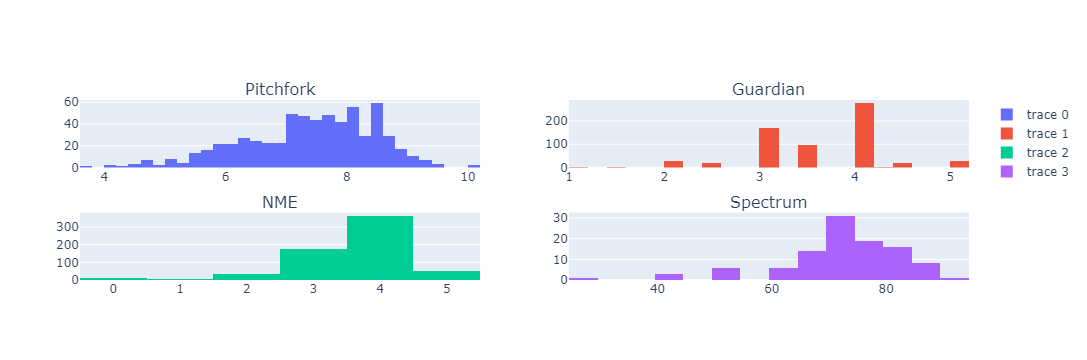

In [43]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(score_dfs.keys()))
i = 0

for platform, df in score_dfs.items():
    
    i += 1
    fig.add_trace(go.Histogram(x=df.loc[:, "Scores"]), row=(i - 1) // 2 + 1, col=(i + 1) % 2 + 1)
    
fig

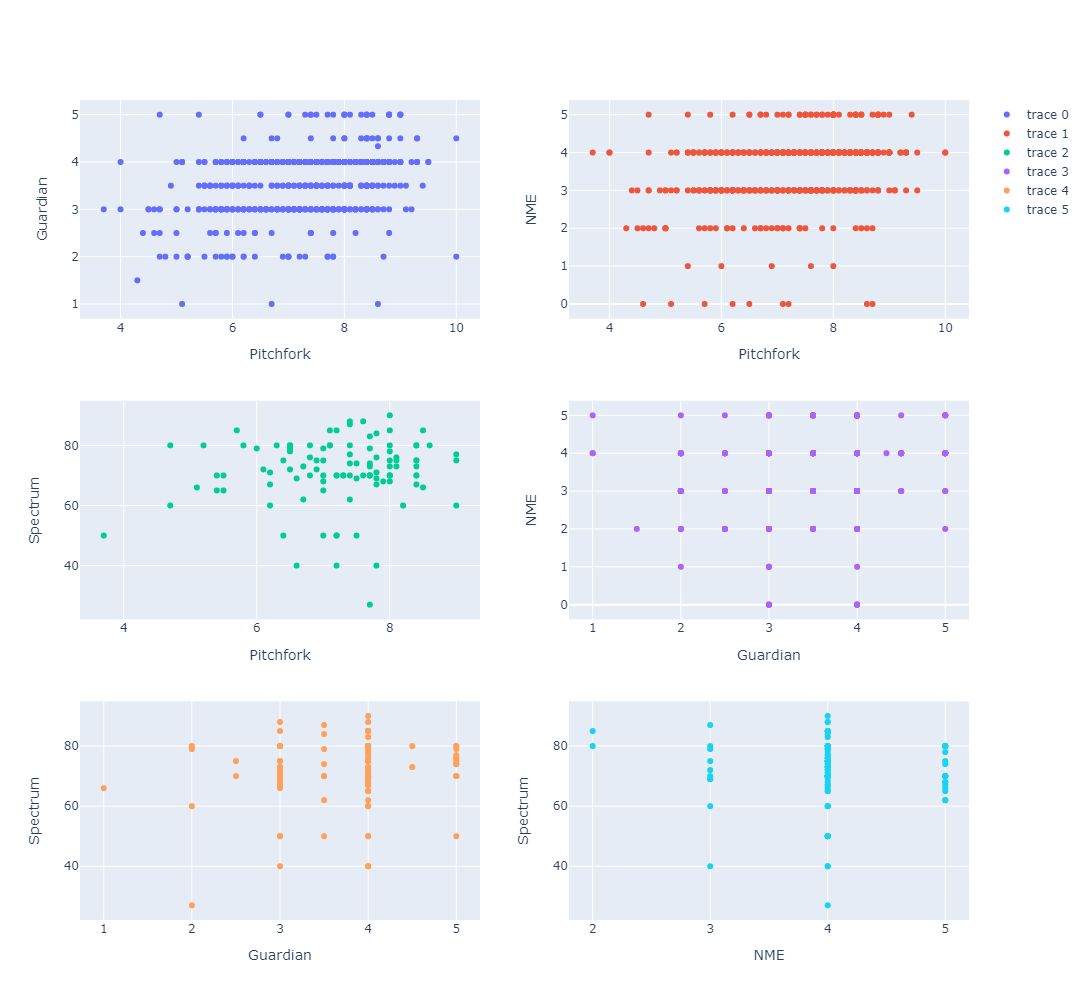

In [44]:
fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(score_dfs.keys())[i], list(score_dfs.values())[i]
        k2, df2 = list(score_dfs.keys())[j], list(score_dfs.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist", "Album"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"], y=joined_scores.loc[:, "Scores2"], mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

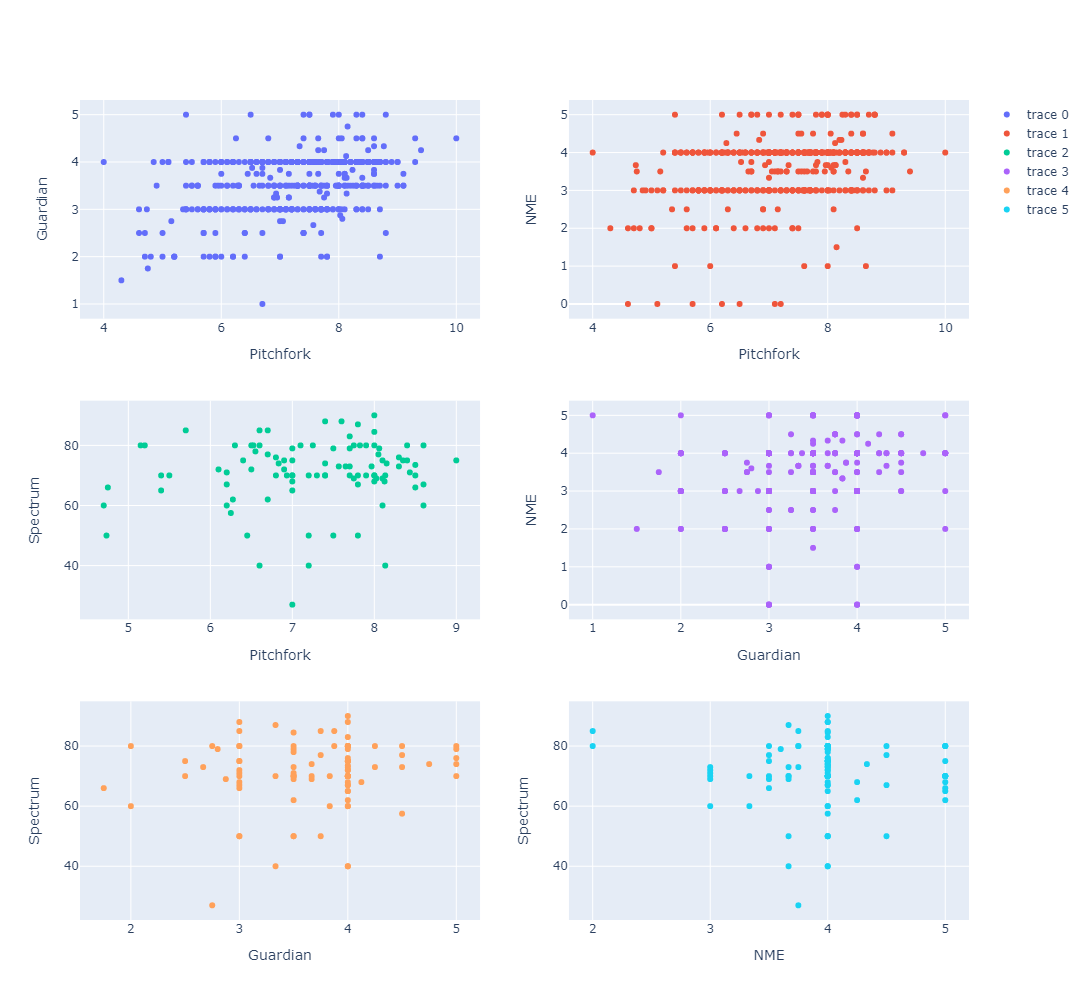

In [45]:
artist_ave = {platform: df.groupby("Artist")["Scores"].mean().reset_index() for platform, df in score_dfs.items()}

fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(artist_ave.keys())[i], list(artist_ave.values())[i]
        k2, df2 = list(artist_ave.keys())[j], list(artist_ave.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"], y=joined_scores.loc[:, "Scores2"], mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

In [46]:
std_scores = {}

all_scores = score_dfs["Pitchfork"].loc[:, [col not in ["Url", "Text", "Platform"] for col in score_dfs["Pitchfork"].columns]].rename({"Scores": "Pitchfork Scores"}, axis=1)

for platform in ["Guardian", "NME"]:
    
    next_platform = score_dfs[platform].loc[:, [col not in ["Url", "Text", "Platform", "Genres"] for col in score_dfs[platform].columns]].rename({"Scores": f"{platform} Scores"}, axis=1)
    all_scores = pd.merge(all_scores, next_platform,
                          on=["Artist", "Album"])

all_scores.loc[:, "Guardian Scores"] = all_scores.loc[:, "Guardian Scores"].multiply(2)
all_scores.loc[:, "NME Scores"] = all_scores.loc[:, "NME Scores"].astype(float).multiply(2)
all_scores = all_scores.sort_values(by="Album").reset_index(drop=True)

averages = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores"]].mean(axis=1)

sp_filled = dfs_ave["Spectrum"].copy().sort_values(by="Album").reset_index(drop=True)
sp_no_data = sp_filled["Scores"] == -1
sp_filled.loc[~sp_no_data, "Scores"] = sp_filled.loc[~sp_no_data, "Scores"].div(10)
sp_filled.loc[sp_no_data, "Scores"] = averages.loc[sp_no_data]
sp_filled = sp_filled.rename({"Scores": "Spectrum Scores"}, axis=1).drop(["Platform", "Url"], axis=1)

all_scores = pd.merge(all_scores, sp_filled, on=["Artist", "Album"])

all_scores["Average Score"] = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

all_scores.head()

Artist Album  Pitchfork Scores     Genres  Guardian Scores  \
0  taylor swift  1989               7.7  [Pop/R&B]              8.0   
1   mac demarco     2               8.2     [Rock]              6.0   
2         adele    25               7.3  [Pop/R&B]              6.0   
3          2:54  2:54               6.0  [Pop/R&B]              4.0   
4       beyonce     4               8.0  [Pop/R&B]              7.0   

   NME Scores                                               Text  \
0         6.0  \n[xrr rating=3.5/5]The Fall’s 30 studio album...   
1         8.0  \n[xrr rating=2.75/5]As concept albums go, it ...   
2         6.0  \nWhat do avant-garde composer John Zorn and s...   
3         8.0  \n[xrr rating=3.5/5]Eventually we’re going to ...   
4         4.0  \n\n“Weird Al” Yankovic \nAlpocalypse \nRating...   

   Spectrum Scores  Average Score  
0         7.233333       7.233333  
1         7.400000       7.400000  
2         6.433333       6.433333  
3         6.000000       6.000000  
4         6.333333       6.333333

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(scoring, df):
    sp_error = scoring(df.loc[~sp_no_data, "Spectrum Scores"], df.loc[~sp_no_data, "Average Score"])
    errors = {platform: scoring(df.loc[:, f"{platform} Scores"], df.loc[:, "Average Score"]) for platform in platforms}
    errors["Spectrum"] = sp_error

    return pd.DataFrame(errors, index=["Platform"]).T

get_error(mean_squared_error, all_scores)

Platform
Pitchfork  0.693770
Guardian   1.000827
NME        1.361620
Spectrum   1.162536

In [48]:
get_error(mean_absolute_error, all_scores)

Platform
Pitchfork  0.636523
Guardian   0.751213
NME        0.851101
Spectrum   0.862381

In [49]:
sp_errors = all_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
errors = {platform: all_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
errors["Spectrum"] = sp_errors

errors_df = pd.DataFrame(errors)

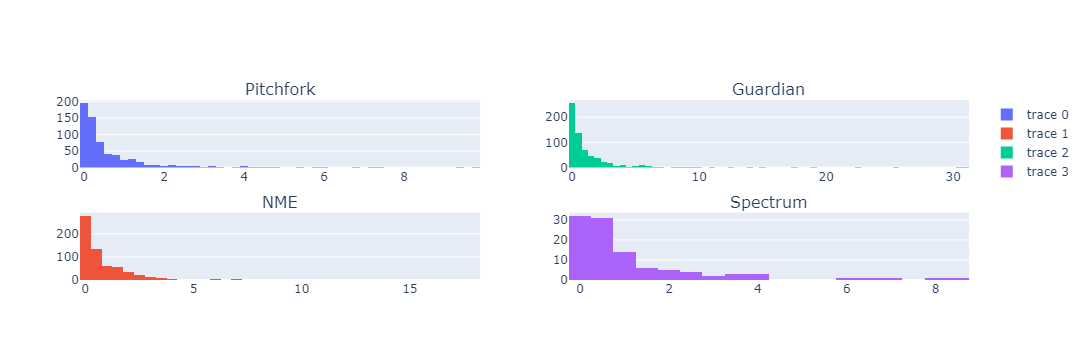

In [50]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(platforms))

i = 0

for platform in platforms:

    i += 1
    fig.add_trace(go.Histogram(x=errors_df.loc[:, platform]), row=(i - 1) % 2 + 1, col=(i - 1) // 2 + 1)
    
fig

In [51]:
errors_df = pd.merge(errors_df, all_scores, left_index=True, right_index=True)
errors_df

Pitchfork  Guardian       NME  Spectrum        Artist           Album  \
0     0.217778  0.587778  1.521111       NaN  taylor swift            1989   
1     0.640000  1.960000  0.360000       NaN   mac demarco               2   
2     0.751111  0.187778  0.187778       NaN         adele              25   
3     0.000000  4.000000  4.000000       NaN          2:54            2:54   
4     2.777778  0.444444  5.444444       NaN       beyonce               4   
..         ...       ...       ...       ...           ...             ...   
636   1.000000  0.250000  0.250000       NaN    kanye west          yeezus   
637   0.217778  1.521111  0.587778       NaN  flying lotus    you're dead!   
638   1.137778  2.351111  0.217778       NaN        iceage  you're nothing   
639   0.017778  3.737778  4.271111       NaN   marvin gaye  you're the man   
640   0.004444  0.001111  0.001111       NaN          yuck            yuck   

     Pitchfork Scores        Genres  Guardian Scores  NME Scores  \
0                 7.7     [Pop/R&B]              8.0         6.0   
1                 8.2        [Rock]              6.0         8.0   
2                 7.3     [Pop/R&B]              6.0         6.0   
3                 6.0     [Pop/R&B]              4.0         8.0   
4                 8.0     [Pop/R&B]              7.0         4.0   
..                ...           ...              ...         ...   
636               9.5         [Rap]              8.0         8.0   
637               8.3  [Electronic]             10.0         8.0   
638               8.6        [Rock]              6.0         8.0   
639               7.8     [Pop/R&B]              6.0        10.0   
640               8.1        [Rock]              8.0         8.0   

                                                  Text  Spectrum Scores  \
0    \n[xrr rating=3.5/5]The Fall’s 30 studio album...         7.233333   
1    \n[xrr rating=2.75/5]As concept albums go, it ...         7.400000   
2    \nWhat do avant-garde composer John Zorn and s...         6.433333   
3    \n[xrr rating=3.5/5]Eventually we’re going to ...         6.000000   
4    \n\n“Weird Al” Yankovic \nAlpocalypse \nRating...         6.333333   
..                                                 ...              ...   
636  \n[xrr rating=3.5/5]In certain indie music cir...         8.500000   
637  \n[xrr rating=3.75/5]What do we expect of Leon...         8.766667   
638  \n[xrr rating=3.5/5]Critics have nearly exhaus...         7.533333   
639  \nWe are currently experiencing a boom period ...         7.933333   
640  \n\nTim Hecker\nRavedeath, 1972\nRating: 4.2/5...         8.033333   

     Average Score  
0         7.233333  
1         7.400000  
2         6.433333  
3         6.000000  
4         6.333333  
..             ...  
636       8.500000  
637       8.766667  
638       7.533333  
639       7.933333  
640       8.033333  

[641 rows x 13 columns]

In [52]:
errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean()

Pitchfork  Spectrum  Guardian       NME
Genres                                               
Electronic     0.818393  0.913906  1.178187  1.738112
Experimental   0.956125  0.637187  1.165896  1.417620
Folk/Country   0.350705  1.407375  0.540705  0.961538
Global         0.581333       NaN  0.905333  0.385333
Jazz           1.921481  0.360000  2.574815  0.885926
Metal          1.001366  0.543542  1.307662  1.170625
NA             0.223704       NaN  0.581852  0.530000
Pop/R&B        0.628843  1.150000  0.817593  1.359512
Rap            0.986020  1.256313  1.676053  1.152196
Rock           0.653285  1.327615  0.944250  1.347645

In [53]:
all_star_scores = all_scores.copy()

for platform in platforms:
    
    all_star_scores.loc[:, f"{platform} Scores"] = all_star_scores.loc[:, f"{platform} Scores"].div(2).apply(ceil)
    
all_star_scores.loc[:, "Average Score"] = all_star_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

In [54]:
all_star_scores

Artist           Album  Pitchfork Scores        Genres  \
0    taylor swift            1989                 4     [Pop/R&B]   
1     mac demarco               2                 5        [Rock]   
2           adele              25                 4     [Pop/R&B]   
3            2:54            2:54                 3     [Pop/R&B]   
4         beyonce               4                 4     [Pop/R&B]   
..            ...             ...               ...           ...   
636    kanye west          yeezus                 5         [Rap]   
637  flying lotus    you're dead!                 5  [Electronic]   
638        iceage  you're nothing                 5        [Rock]   
639   marvin gaye  you're the man                 4     [Pop/R&B]   
640          yuck            yuck                 5        [Rock]   

     Guardian Scores  NME Scores  \
0                  4           3   
1                  3           4   
2                  3           3   
3                  2           4   
4                  4           2   
..               ...         ...   
636                4           4   
637                5           4   
638                3           4   
639                3           5   
640                4           4   

                                                  Text  Spectrum Scores  \
0    \n[xrr rating=3.5/5]The Fall’s 30 studio album...                4   
1    \n[xrr rating=2.75/5]As concept albums go, it ...                4   
2    \nWhat do avant-garde composer John Zorn and s...                4   
3    \n[xrr rating=3.5/5]Eventually we’re going to ...                3   
4    \n\n“Weird Al” Yankovic \nAlpocalypse \nRating...                4   
..                                                 ...              ...   
636  \n[xrr rating=3.5/5]In certain indie music cir...                5   
637  \n[xrr rating=3.75/5]What do we expect of Leon...                5   
638  \n[xrr rating=3.5/5]Critics have nearly exhaus...                4   
639  \nWe are currently experiencing a boom period ...                4   
640  \n\nTim Hecker\nRavedeath, 1972\nRating: 4.2/5...                5   

     Average Score  
0             3.75  
1             4.00  
2             3.50  
3             3.00  
4             3.50  
..             ...  
636           4.50  
637           4.75  
638           4.00  
639           4.00  
640           4.50  

[641 rows x 9 columns]

In [55]:
get_error(mean_squared_error, all_star_scores)

Platform
Pitchfork  0.294754
Guardian   0.308015
NME        0.428140
Spectrum   0.294048

In [56]:
get_error(mean_absolute_error, all_star_scores)

Platform
Pitchfork  0.406786
Guardian   0.412246
NME        0.469189
Spectrum   0.395238

In [57]:
sp_star_errors = all_star_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
star_errors = {platform: all_star_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
star_errors["Spectrum"] = sp_star_errors

star_errors_df = pd.DataFrame(star_errors)

In [58]:
star_errors_df = pd.merge(star_errors_df, all_star_scores, left_index=True, right_index=True)

In [59]:
star_errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean().style.highlight_max(axis=1, color="pink")

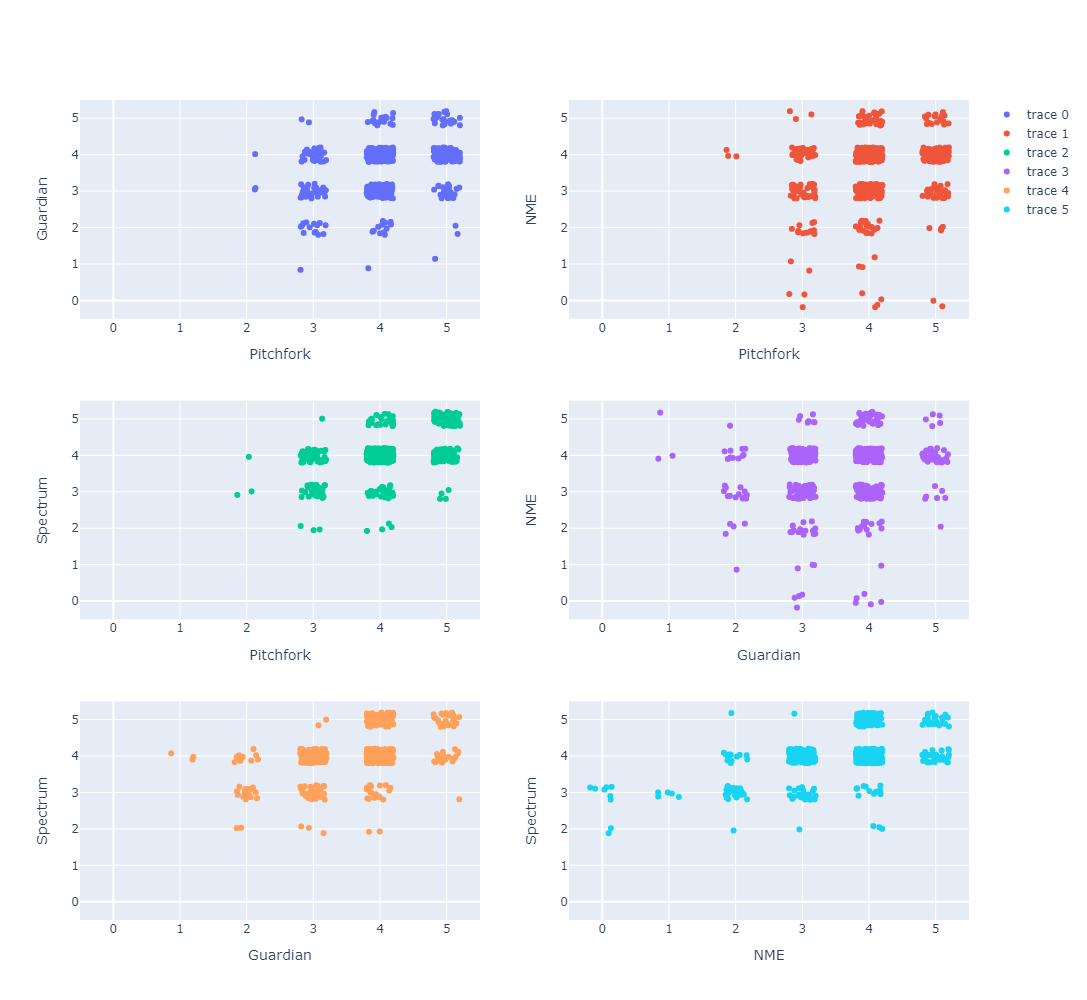

In [60]:
fig = make_subplots(rows=3, cols=2)
import random

def jitter(x, intensity):
    
    return x + np.random.uniform(low=-intensity, high=intensity)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1 = platforms[i]
        k2 = platforms[j]
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=all_star_scores.loc[:, f"{k1} Scores"].apply(jitter, intensity=0.2), 
                                 y=all_star_scores.loc[:, f"{k2} Scores"].apply(jitter, intensity=0.2), 
                                 mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col, range=[-0.5, 5.5])
        fig.update_yaxes(title_text=k2, row=row, col=col, range=[-0.5, 5.5])
        
    fig.update_layout(height=1000)
        
fig

In [61]:
all_star_scores.loc[:, [f"{platform} Scores" for platform in platforms]].corr()

Pitchfork Scores  Guardian Scores  NME Scores  \
Pitchfork Scores          1.000000         0.313869    0.215333   
Guardian Scores           0.313869         1.000000    0.191707   
NME Scores                0.215333         0.191707    1.000000   
Spectrum Scores           0.520022         0.453597    0.522122   

                  Spectrum Scores  
Pitchfork Scores         0.520022  
Guardian Scores          0.453597  
NME Scores               0.522122  
Spectrum Scores          1.000000

In [62]:
all_scores.head(30).loc[7:20, all_scores.columns != "Text"]

Artist                                      Album  \
7             wutang clan                          a better tomorrow   
8                the 1975  a brief inquiry into online relationships   
9               sheer mag                             a distant call   
10  everything everything                              a fever dream   
11          the districts                     a flourish and a spoil   
12           fontaines dc                             a hero's death   
13                 m ward                      a wasteland companion   
14             the weeknd                                after hours   
15           broken bells                            after the disco   
16            merchandise                              after the end   
17             goodie mob                    age against the machine   
18            angel olsen                                all mirrors   
19         arctic monkeys                                         am   
20             dan deacon                                    america   

    Pitchfork Scores              Genres  Guardian Scores  NME Scores  \
7                5.9               [Rap]              6.0         6.0   
8                8.5              [Rock]              8.0        10.0   
9                7.8              [Rock]              8.0         8.0   
10               7.1              [Rock]              8.0         8.0   
11               5.6              [Rock]              6.0         8.0   
12               8.1              [Rock]             10.0         8.0   
13               6.3              [Rock]              7.0         6.0   
14               7.9           [Pop/R&B]              8.0         8.0   
15               5.4  [Electronic, Rock]              6.0         8.0   
16               7.0              [Rock]              6.0         8.0   
17               6.8      [Pop/R&B, Rap]              6.0         8.0   
18               8.9              [Rock]              7.0        10.0   
19               8.0              [Rock]              8.0        10.0   
20               7.1        [Electronic]              8.0         8.0   

    Spectrum Scores  Average Score  
7          5.966667       5.966667  
8          8.833333       8.833333  
9          7.933333       7.933333  
10         7.700000       7.700000  
11         6.533333       6.533333  
12         7.600000       8.425000  
13         6.433333       6.433333  
14         7.966667       7.966667  
15         6.466667       6.466667  
16         7.000000       7.000000  
17         6.933333       6.933333  
18         8.633333       8.633333  
19         8.666667       8.666667  
20         7.700000       7.700000

In [70]:
all_star_scores.loc[all_star_scores["NME Scores"] == 0, "NME Scores"] = 1

In [79]:
# Guardian and Pitchfork

from scipy import stats

n = 5
k = 2

P = ((n - 1) * sum([2 ** (x - 1) for x in range(1, k)]) + n) / n ** k

N1 = sum(all_star_scores["Guardian Scores"] == all_star_scores["Pitchfork Scores"])
N = all_star_scores.shape[0]

T = (N1 - N * P) / (N - N * P)

N2 = N - N1

chi_2 = ((N1 - N * P - 0.5) ** 2) / (N * P) + ((N2 - N * (1 - P) - 0.5) ** 2) / (N * (1 - P))
p_value = 1 - stats.chi2.cdf(chi_2, 1)

p_value

5.783036428619326e-06

In [90]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

melted = pd.melt(all_star_scores.loc[:, ["Artist", "Album", "Pitchfork Scores", "Guardian Scores"]], id_vars=["Artist", "Album"],
                 value_vars=["Pitchfork Scores", "Guardian Scores"])

melted.columns=["Arist", "Album", "Platform", "Scores"]

model = ols("Scores ~ C(Platform)", data=melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df           F        PR(>F)
C(Platform)   63.358034     1.0  140.634131  7.467233e-31
Residual     576.661466  1280.0         NaN           NaN